In [1]:
import io
import pandas as pd
df = pd.read_csv('/Users/inakolluvishnusai/tensorflow/Sarayu/New Data 1.csv') # Dataset is now stored in a Pandas Dataframe

print(df.head())

   Id                                           Judgment  Judgment Status
0   1  appeal judgment decre bombay high court stone ...                1
1   2  applic articl 32 1 constitut enforc applic fun...                2
2   3  appeal judgment high court hyderabad articl 37...                0
3   4  appeal articl 3744 constitut judgment decre hi...                0
4   5  petit art 136 constitut pray special leav appe...                3


In [2]:
sentences = df[['Judgment','Judgment Status']]

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(sentences,  test_size=0.25, random_state=42)

In [3]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(df_train['Judgment Status'])
y_test = to_categorical(df_test['Judgment Status'])

In [4]:
import transformers
from transformers import AutoTokenizer,TFRobertaModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

2023-06-06 21:18:55.091190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-06 21:18:55.091727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [5]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=df_train.Judgment.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=df_test.Judgment.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [6]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [7]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [8]:
max_len = 100
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = roberta_model(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [9]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model.compile(
    optimizer = optimizer,
    loss=loss, 
    metrics = metric)

In [11]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=10,
    batch_size=64
)

Epoch 1/10
5/5 [==============================] - 36s 7s/step - loss: 1.3663 - balanced_accuracy: 0.3177 - val_loss: 1.2778 - val_balanced_accuracy: 0.3763
Epoch 2/10
5/5 [==============================] - 37s 7s/step - loss: 1.3191 - balanced_accuracy: 0.3466 - val_loss: 1.2412 - val_balanced_accuracy: 0.3656
Epoch 3/10
5/5 [==============================] - 33s 6s/step - loss: 1.2665 - balanced_accuracy: 0.3971 - val_loss: 1.2326 - val_balanced_accuracy: 0.3871
Epoch 4/10
5/5 [==============================] - 33s 6s/step - loss: 1.2099 - balanced_accuracy: 0.4224 - val_loss: 1.3083 - val_balanced_accuracy: 0.3548
Epoch 5/10
5/5 [==============================] - 32s 6s/step - loss: 1.2662 - balanced_accuracy: 0.4007 - val_loss: 1.1661 - val_balanced_accuracy: 0.4516
Epoch 6/10
5/5 [==============================] - 30s 6s/step - loss: 1.2318 - balanced_accuracy: 0.4079 - val_loss: 1.1363 - val_balanced_accuracy: 0.4086
Epoch 7/10
5/5 [==============================] - 31s 6s/step - 

In [12]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

2023-06-06 21:26:20.340742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 11s 3s/step


array([0.36326504, 0.2388113 , 0.73357916, 0.6780571 ], dtype=float32)

In [13]:
import numpy as np

y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = df_test['Judgment Status']

In [14]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_true, y_predicted))

print(accuracy_score(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.50      0.03      0.06        30
           1       0.47      0.79      0.59        34
           2       0.42      0.73      0.54        15
           3       0.29      0.14      0.19        14

    accuracy                           0.44        93
   macro avg       0.42      0.43      0.34        93
weighted avg       0.44      0.44      0.35        93

0.44086021505376344


In [15]:
x_train ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']}

loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.5415


In [16]:
x_test = {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}

loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.4409


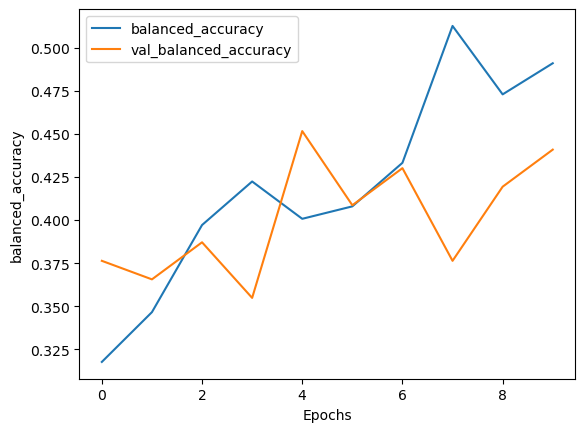

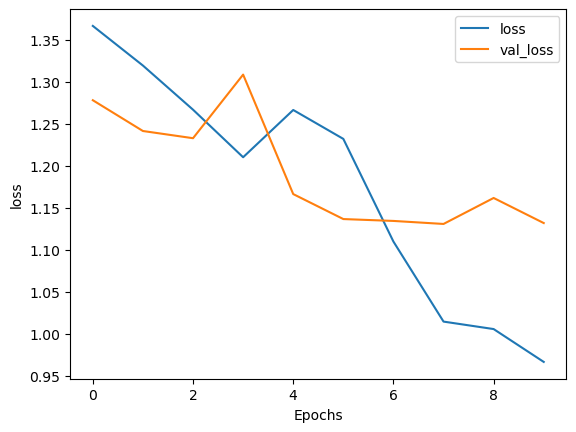

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(train_history, "balanced_accuracy")
plot_graphs(train_history, "loss")

In [18]:
model.save("BERT-Roberta.h5")